In [1]:
import os, sys, subprocess, shutil, shlex
from pathlib import Path
import urllib.request


In [2]:
from pathlib import Path
import urllib.request
import subprocess
import os

# 1) Jump to the Git repo root (fallback: climb until it finds pyproject.toml/.git)
try:
    ROOT = subprocess.check_output(["git", "rev-parse", "--show-toplevel"], text=True).strip()
except Exception:
    # fallback: walk up parents until we see a marker file/folder
    here = Path.cwd()
    for p in [here, *here.parents]:
        if (p / ".git").exists() or (p / "pyproject.toml").exists():
            ROOT = str(p); break
    else:
        ROOT = str(here)  # last resort
os.chdir(ROOT)
print("Project root:", Path.cwd())

# 2) Paths now relative to the repo root
CKPTS = Path("ckpts")
CKPTS.mkdir(exist_ok=True)

vjepa_pt = CKPTS / "vjepa2_vitl_256.pt"
head_pt = CKPTS / "head_linear_fpn_best.pt"

# Download backbone model if it doesn't exist
if not vjepa_pt.exists():
    print("Downloading backbone model from Meta server...")
    url = "https://dl.fbaipublicfiles.com/vjepa2/vitl.pt"
    urllib.request.urlretrieve(url, vjepa_pt)
    print("Download finished:", vjepa_pt)

# Download head checkpoint if it doesn't exist
if not head_pt.exists():
    print("Downloading head checkpoint from repo release...")
    url = "https://github.com/PouyaRepos/vjepa_segmentation/releases/download/head/head_linear_fpn_best.pt"
    urllib.request.urlretrieve(url, head_pt)
    print("Download finished:", head_pt)

# Print status and sizes
print("Backbone exists?", vjepa_pt.exists())
print("Head exists?", head_pt.exists())

# Show sizes if files exist
if vjepa_pt.exists():
    print("Backbone size:", vjepa_pt.stat().st_size, "bytes")
if head_pt.exists():
    print("Head size:", head_pt.stat().st_size, "bytes")

Project root: /Users/pouyaabbasi/Documents/Projects/vjepa_segmentation
Backbone exists? True
Head exists? True
Backbone size: 5127726842 bytes
Head size: 1123404 bytes


In [4]:

REPO_URL = "https://github.com/PouyaRepos/vjepa_segmentation.git"  
BRANCH   = "feature/vjepa2-hub"  # branch with V-JEPA 2.0 support
HEAD_URL = "https://github.com/PouyaRepos/vjepa_segmentation/releases#:~:text=Update%20README.md-,Assets,-3"

# sample inputs
IMAGE_PATH = "samples/person.jpg"
VIDEO_PATH = "samples/clip.mp4"

print("REPO_URL:", REPO_URL)
print("BRANCH:", BRANCH)
print("HEAD_URL set:", bool(HEAD_URL))
print("IMAGE_PATH:", IMAGE_PATH)
print("VIDEO_PATH:", VIDEO_PATH)

REPO_URL: https://github.com/PouyaRepos/vjepa_segmentation.git
BRANCH: feature/vjepa2-hub
HEAD_URL set: True
IMAGE_PATH: samples/person.jpg
VIDEO_PATH: samples/clip.mp4


In [6]:
!nvidia-smi -L || echo "No GPU (that's ok, but slower)"
!python --version
!pip -q install -U pip
# core libs
!pip -q install timm einops opencv-python

zsh:1: command not found: nvidia-smi
No GPU (that's ok, but slower)
Python 3.9.21


In [8]:
# --- Robust repo bootstrap + import ---
import os, sys, subprocess, importlib
from pathlib import Path
from IPython import get_ipython

REPO_URL = "https://github.com/PouyaRepos/vjepa_segmentation.git"
BRANCH   = "feature/vjepa2-hub"  # branch with V-JEPA 2.0 support

def find_repo_root(start: Path):
    for q in [start, *start.parents]:
        if (q / "pyproject.toml").exists() or (q / ".git").exists():
            return q
    return None

# 1) Locate or clone repo, then chdir into it
root = find_repo_root(Path.cwd())
if root is None:
    if not Path("vjepa_segmentation").exists():
        print("Cloning repo…")
        get_ipython().system(f'git clone -b "{BRANCH}" "{REPO_URL}" vjepa_segmentation')
    os.chdir("vjepa_segmentation")
    root = Path.cwd()
    print("Entered cloned repo root:", root)
else:
    os.chdir(root)
    print("Using existing repo root:", Path.cwd())

# 2) Ensure common dirs
Path("ckpts").mkdir(exist_ok=True)
Path("media").mkdir(exist_ok=True)

# 3) Make sure Python can see both root and src layouts
for p in [str(root), str(root / "src")]:
    if p not in sys.path:
        sys.path.insert(0, p)

def try_import():
    try:
        import vjepa_seg  # preferred import if package folder is src/vjepa_seg/
        return "vjepa_seg"
    except ModuleNotFoundError:
        pass
    try:
        import vjepa_segmentation  # fallback if package folder is src/vjepa_segmentation/
        return "vjepa_segmentation"
    except ModuleNotFoundError:
        return None

# 4) Try import; if it fails, install editable and retry
pkg = try_import()
if pkg:
    print(f"Package import OK: {pkg}")
else:
    print("Installing package (requirements + editable)…")
    get_ipython().system('pip -q install -r requirements.txt || true')
    get_ipython().system('pip -q install -e .')
    importlib.invalidate_caches()
    # Re-ensure paths in case pip altered environment
    for p in [str(root), str(root / "src")]:
        if p not in sys.path:
            sys.path.insert(0, p)
    pkg = try_import()
    if not pkg:
        raise ModuleNotFoundError(
            "Could not import the package. Check that your package folder is "
            "`src/vjepa_seg/` (or `src/vjepa_segmentation/`) and contains an __init__.py, "
            "and that pyproject.toml includes it (e.g., [tool.setuptools.packages.find] "
            'where=["src"], include=["vjepa_seg*"]).'
        )
    print(f"Installed and imported: {pkg}")


Using existing repo root: /Users/pouyaabbasi/Documents/Projects/vjepa_segmentation
Package import OK: vjepa_seg


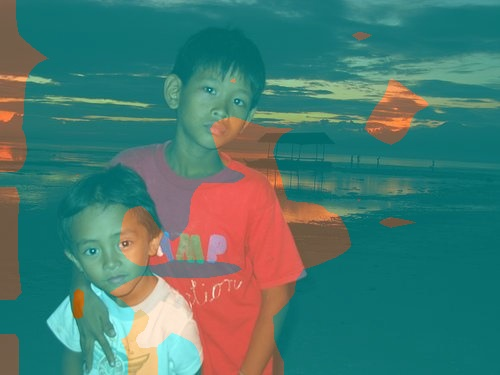

/Users/pouyaabbasi/Documents/Projects/vjepa_segmentation/.venv/bin/python: Error while finding module specification for 'vjepa_seg.inference' (ModuleNotFoundError: No module named 'vjepa_seg')


In [9]:
%%capture --no-display

def run(cmd_list):
    print("RUN:", " ".join(shlex.quote(c) for c in cmd_list))
    return subprocess.run(cmd_list, check=False)

img_exists = os.path.exists(IMAGE_PATH)
have_head = os.path.exists("ckpts/head_linear_fpn_best.pt")
have_back = os.path.exists("ckpts/vjepa2_vitl_256.pt")

if not img_exists:
    print("Image not found:", IMAGE_PATH)
else:
    os.makedirs("media", exist_ok=True)
    if have_head and have_back:
        cmd = [
            "python","-m","vjepa_seg.inference",
            "--config","configs/cihp_linear_fpn.yaml",
            "--image", IMAGE_PATH,
            "--out","media/demo_image_overlay.jpg",
            "--ckpt","ckpts/head_linear_fpn_best.pt",
            "--vjepa_ckpt","ckpts/vjepa2_vitl_256.pt",
        ]
    else:
        cmd = [
            "python","-m","vjepa_seg.inference",
            "--config","configs/cihp_linear_fpn.yaml",
            "--image", IMAGE_PATH,
            "--out","media/smoke_out.png",
            "--ckpt","",
            "--dummy_backbone","1",
        ]
    run(cmd)

from IPython.display import Image, display
if os.path.exists("media/demo_image_overlay.jpg"):
    display(Image(filename="media/demo_image_overlay.jpg"))
elif os.path.exists("media/smoke_out.png"):
    display(Image(filename="media/smoke_out.png"))

In [10]:
%%capture --no-display
import os, shlex, subprocess
from IPython.display import Video, HTML, display

VIDEO_PATH = "samples/clip.mp4"
os.makedirs("media", exist_ok=True)

def sh(cmd):
    print("RUN:", " ".join(shlex.quote(c) for c in cmd))
    return subprocess.run(cmd, check=False, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

have_head = os.path.exists("ckpts/head_linear_fpn_best.pt")
have_back = os.path.exists("ckpts/vjepa2_vitl_256.pt")

cmd = [
    "python","-m","vjepa_seg.inference",
    "--config","configs/cihp_linear_fpn.yaml",
    "--video", VIDEO_PATH,
    "--out","out.mp4",
]
if have_head and have_back:
    cmd += ["--ema","0.6","--ckpt","ckpts/head_linear_fpn_best.pt","--vjepa_ckpt","ckpts/vjepa2_vitl_256.pt"]
else:
    cmd += ["--ema","0.0","--ckpt","","--dummy_backbone","1"]

# 1) Run inference
res = sh(cmd)
print(res.stdout)

# 2) Ensure result exists
if not os.path.exists("out.mp4") or os.path.getsize("out.mp4") == 0:
    raise FileNotFoundError("out.mp4 was not produced. Check the logs above.")

# 3) Re-encode to HTML5-friendly H.264 (Chrome/Colab needs avc1/yuv420p)
#    Also scale to a multiple of 2 for H.264 and make it seekable (+faststart)
res = sh([
    "ffmpeg","-y","-i","out.mp4",
    "-vf","scale=512:-2",              # keep aspect; height multiple of 2
    "-c:v","libx264","-pix_fmt","yuv420p",
    "-preset","veryfast","-crf","23",
    "-movflags","+faststart",
    "out_web.mp4"
])
print(res.stdout)

if not os.path.exists("out_web.mp4") or os.path.getsize("out_web.mp4") == 0:
    # Fallback: try a short GIF so at least something shows inline
    sh(["ffmpeg","-y","-i","out.mp4","-vf","fps=15,scale=512:-1:flags=lanczos","-t","4","media/demo_video.gif"])
    if os.path.exists("media/demo_video.gif"):
        display(HTML('<img src="media/demo_video.gif" />'))
    else:
        raise RuntimeError("Re-encode failed and GIF fallback failed.")
else:
    # 4) Show inline in Colab
    display(Video("out_web.mp4", embed=True, html_attributes="controls loop playsinline"))
